Downloading data

In [ ]:
!pip install nltk

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from gensim.models import Word2Vec


In [ ]:
# Glove dictionary 300 dimentions
!wget https://www.cse.iitb.ac.in/~kartavya/glove_dict_tensor.pkl

--2020-10-29 09:42:30--  https://www.cse.iitb.ac.in/~kartavya/glove_dict_tensor.pkl
Resolving www.cse.iitb.ac.in (www.cse.iitb.ac.in)... 103.21.127.134
Connecting to www.cse.iitb.ac.in (www.cse.iitb.ac.in)|103.21.127.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 770589404 (735M)
Saving to: ‘glove_dict_tensor.pkl.3’

glove_dict_tensor.p 100%[===================>] 734.89M  5.29MB/s    in 2m 28s  

2020-10-29 09:45:00 (4.95 MB/s) - ‘glove_dict_tensor.pkl.3’ saved [770589404/770589404]



Load the glove dictionary

In [ ]:
import pickle
pickle_in = open("glove_dict_tensor.pkl","rb")
glove = pickle.load(pickle_in)

In [ ]:
!wget -q https://www.cse.iitb.ac.in/~sourabj/dataset2/train.txt
!wget -q https://www.cse.iitb.ac.in/~sourabj/dataset2/test.txt

def load_and_process(filepath):
    df = np.loadtxt(filepath, dtype=str)
    df[:, -1] = np.vectorize(lambda x: x.split('-')[0])(df[:,-1])
    cutfrom = 0
    sentences = []
    for i in range(df.shape[0]):
        # print(ts[i])
        if df[i][0] == '.':
            sentences.append(df[cutfrom:i+1].T)
            cutfrom = i + 1
    return sentences


testset = load_and_process("test.txt")
trainset = load_and_process("train.txt")

In [ ]:
all_pos = set()
for i in testset:
    all_pos = all_pos.union(set(i[1]))
for i in trainset:
    all_pos = all_pos.union(set(i[1]))
all_pos = list(all_pos)
id2pos = dict(enumerate(all_pos))
pos2id = id2tag = {v: k for k, v in id2pos.items()}

In [ ]:
tag2id = { 
    'B': 0,
    'I': 1,
    'O': 2,
    'PAD': 3
}
id2tag = {v: k for k, v in tag2id.items()}
id2tag

{0: 'B', 1: 'I', 2: 'O', 3: 'PAD'}

In [ ]:
def get_sent_and_tag(trainset):
    sentences = []
    tags = []
    for i, data in enumerate(trainset):
        # print(i, data[0])
        sent = []
        for j, word in enumerate(data[0]):
            word_embed = glove.get(word.lower(), torch.zeros(200))
            posid = 0 #pos2id[data[1][j]]
            posid = torch.tensor([posid])
            word_embed = (torch.cat((word_embed, posid), 0))
            sent.append(word_embed)
            # sent[-1].append(0)
        # sent = ([glove.get(word.lower(), torch.zeros(200)) for word in data[0]])
        sent = torch.cat(sent).view(len(sent),-1)
        if len(sent) < 100:
            sent = torch.cat((sent,torch.zeros((100-len(sent),201))))

        sentences.append(sent[:100])
        sent_tag = data[2][:100].tolist()
        sent_tag.extend(['PAD']*(100-data.shape[1]))

        sent_tag = ([tag2id[x] for x in sent_tag])
        sent_tag = torch.tensor(sent_tag)
        tags.append(sent_tag)
    sentences = torch.stack(sentences)
    tags = torch.stack(tags)
    return sentences, tags
Xtrain, Ytrain = get_sent_and_tag(trainset)
Xtest, Ytest = get_sent_and_tag(testset)

In [ ]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

(torch.Size([8725, 100, 201]),
 torch.Size([8725, 100]),
 torch.Size([1952, 100, 201]),
 torch.Size([1952, 100]))

In [ ]:
# postags = list(np.unique(trainset[:,1]))
# z = np.zeros([trainset.shape[0], len(postags)])
# from sklearn.preprocessing import OneHotEncoder
# testset[:,1] = OneHotEncoder().fit_transform(trainset[:,1].reshape((-1,1)))


In [ ]:
class NET(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, batchSize, seqLength, numClasses):
    super(NET,self).__init__()
    self.batchSize = batchSize
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.bilstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional = True)
    self.fc = nn.Linear(hidden_dim*2,numClasses)

  def forward(self, input_ids):
    # Initialize hidden state
    # h0 = torch.zeros((self.layer_dim*2, input_ids.size(0), self.hidden_dim)).requires_grad_()
    # # Initialize cell state
    # c0 = torch.zeros((self.layer_dim*2, input_ids.size(0), self.hidden_dim)).requires_grad_()
    # BiLSTM
    # print(input_ids.size())
    out , (hn,cn) = self.bilstm(input_ids)
    # print('^^^^^^^^^^^',out.size(0))
    out = self.fc(out)
    # out = F.softmax(out,dim=1)

    return out

def train(model,data,optimizer,loss_criterion, batch_size):
  model.train()
  
  epoch_loss = 0
  epoch_acc = 0
  
  for sentence_batch,tags_batch in data:
    if tags_batch.shape[0]!=batch_size:
      # print("label mismatch")
      continue

    if torch.cuda.is_available():
      sentence_batch = sentence_batch.cuda()
      tags_batch = tags_batch.cuda()
      # label = label.cuda()
    
    optimizer.zero_grad()

    out = model(sentence_batch)
    out = out.view(-1,out.shape[-1])
    tags_batch = tags_batch.view(-1)

    loss=loss_criterion(out, tags_batch)
    acc = categorical_accuracy(out, tags_batch, tag2id['PAD'])

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
  
  return epoch_loss / len(data), epoch_acc / len(data)

def evaluate(model,data,loss_criterion,batch_size):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for sentencAnalysise_batch,tags_batch in data:
      if tags_batch.shape[0]!=batch_size:
        # print("label mismatch")
        continue 

      if torch.cuda.is_available():
        sentence_batch = sentence_batch.cuda()
        tags_batch = tags_batch.cuda()

      out = model(sentence_batch)
      out = out.view(-1,out.shape[-1])
      tags_batch = tags_batch.view(-1)

      loss=loss_criterion(out, tags_batch)
      acc = categorical_accuracy(out, tags_batch, tag2id['PAD'])

      # loss.backward()
      # optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(data), epoch_acc / len(data)
class NET(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, batchSize, seqLength, numClasses):
    super(NET,self).__init__()
    self.batchSize = batchSize
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    self.bilstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional = True)
    self.fc = nn.Linear(hidden_dim*2,numClasses)

  def forward(self, input_ids):
    # Initialize hidden state
    # h0 = torch.zeros((self.layer_dim*2, input_ids.size(0), self.hidden_dim)).requires_grad_()
    # # Initialize cell state
    # c0 = torch.zeros((self.layer_dim*2, input_ids.size(0), self.hidden_dim)).requires_grad_()
    # BiLSTM
    # print(input_ids.size())
    out , (hn,cn) = self.bilstm(input_ids)
    # print('^^^^^^^^^^^',out.size(0))
    out = self.fc(out)
    # out = F.softmax(out,dim=1)

    return out

def train(model,data,optimizer,loss_criterion, batch_size):
  model.train()
  
  epoch_loss = 0
  epoch_acc = 0
  
  for sentence_batch,tags_batch in data:
    if tags_batch.shape[0]!=batch_size:
      # print("label mismatch")
      continue

    if torch.cuda.is_available():
      sentence_batch = sentence_batch.cuda()
      tags_batch = tags_batch.cuda()
      # label = label.cuda()
    
    optimizer.zero_grad()

    out = model(sentence_batch)
    out = out.view(-1,out.shape[-1])
    tags_batch = tags_batch.view(-1)

    loss=loss_criterion(out, tags_batch)
    acc = categorical_accuracy(out, tags_batch, tag2id['PAD'])

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
  
  return epoch_loss / len(data), epoch_acc / len(data)

def evaluate(model,data,loss_criterion,batch_size):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
    for sentence_batch,tags_batch in data:
      if tags_batch.shape[0]!=batch_size:
        # print("label mismatch")
        continue 

      if torch.cuda.is_available():
        sentence_batch = sentence_batch.cuda()
        tags_batch = tags_batch.cuda()

      out = model(sentence_batch)
      out = out.view(-1,out.shape[-1])
      tags_batch = tags_batch.view(-1)

      loss=loss_criterion(out, tags_batch)
      acc = categorical_accuracy(out, tags_batch, tag2id['PAD'])

      # loss.backward()
      # optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(data), epoch_acc / len(data)

def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
  
    max_preds = preds.argmax(dim = 1, keepdim = True).squeeze(1) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    return accuracy_score(max_preds[non_pad_elements].cpu(),y[non_pad_elements].cpu())

In [ ]:
from tqdm import tqdm
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score


input_dim = 201
hidden_dim = 50
layer_dim = 2

batch_size = 32
num_epochs = 10
learning_rate = 1e-3

# import random

model=NET(input_dim, hidden_dim, layer_dim,32,40,13)
model.double()
if torch.cuda.is_available():
  model.cuda()

optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_criterion = nn.CrossEntropyLoss(ignore_index=tag2id['PAD'])

for i in tqdm(range(num_epochs)):
  epoch_accuracy=[]
  epoch_loss=[]

  for i in range(1):
    # X_train, X_test, y_train, y_test = sentences[train_index], sentences[test_index], sentence_tags[train_index], sentence_tags[test_index]
    train_dataset = TensorDataset(Xtrain, Ytrain)
    test_dataset = TensorDataset(Xtest, Ytest)
    X_train, X_test, y_train, y_test = None,None,None,None
    train_index, test_index = None,None
    
    train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        # sampler = RandomSampler(train_dataset), # Select batches randomly #TODO RandomSampler
        batch_size = batch_size, # Trains with this batch size.
    )
    train_dataset = None

    test_dataloader = DataLoader(
        test_dataset,
        # sampler = SequentialSampler(test_dataset),
        batch_size = batch_size
    )
    test_dataset = None

    # if cuda.is_available():

    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_criterion, batch_size)
    train_dataloader = None
    test_loss, test_acc = evaluate(model, test_dataloader, loss_criterion, batch_size)
    test_dataloader = None

    epoch_accuracy.append(test_acc)
    epoch_loss.append(test_loss)

  print ('Accuracy: %f  loss: %f' % (np.mean(epoch_accuracy)*100,np.mean(epoch_loss)) )



 10%|█         | 1/10 [01:17<11:36, 77.42s/it]

Accuracy: 88.255266  loss: 0.313616


 20%|██        | 2/10 [02:34<10:19, 77.47s/it]

Accuracy: 91.721040  loss: 0.229831


 30%|███       | 3/10 [03:52<09:02, 77.50s/it]

Accuracy: 92.801617  loss: 0.202078


 40%|████      | 4/10 [05:10<07:45, 77.56s/it]

Accuracy: 93.531929  loss: 0.183862


 50%|█████     | 5/10 [06:28<06:28, 77.78s/it]

Accuracy: 94.095743  loss: 0.170557


 60%|██████    | 6/10 [07:46<05:11, 77.96s/it]

Accuracy: 94.534543  loss: 0.161797


 70%|███████   | 7/10 [09:05<03:54, 78.03s/it]

Accuracy: 94.674581  loss: 0.156936


 80%|████████  | 8/10 [10:23<02:36, 78.18s/it]

Accuracy: 94.806968  loss: 0.155073


 90%|█████████ | 9/10 [11:43<01:18, 78.75s/it]

Accuracy: 94.884084  loss: 0.155561


100%|██████████| 10/10 [13:02<00:00, 78.30s/it]

Accuracy: 94.882098  loss: 0.157165


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

def TestEvaluation(model, testSet):
  model.eval()
  pred_flat = []
  labels_flat = [] 
  
  for batch in testSet:
    # print(batch)
    # b_input_ids = batch[0]
    # # b_input_mask = batch[1].to(device)
    # b_labels = batch[1]
    # if b_labels.shape[0]!=batch_size:
    #   continue
    labels = batch[2]

    with torch.no_grad():
    #   out = model(b_input_ids)
      pred = predict(batch, model)
    # preds = out.detach().numpy()
    # pred_flat.extend(np.argmax(preds, axis=1).flatten().tolist())
    # labels_flat.extend(b_labels.cpu().numpy().flatten().tolist())
    labels_flat.extend(batch[2].tolist())
    pred_flat.extend(pred)

  print("Test Accuracy:", accuracy_score(labels_flat, pred_flat))
  print(classification_report(labels_flat, pred_flat, digits=3))
  return labels_flat, pred_flat
l, p = TestEvaluation(model, testset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy: 0.9482962462525862
              precision    recall  f1-score   support

           B      0.959     0.956     0.958     23846
           I      0.929     0.943     0.936     17340
           O      0.962     0.931     0.946      6180

    accuracy                          0.948     47366
   macro avg      0.950     0.944     0.947     47366
weighted avg      0.948     0.948     0.948     47366



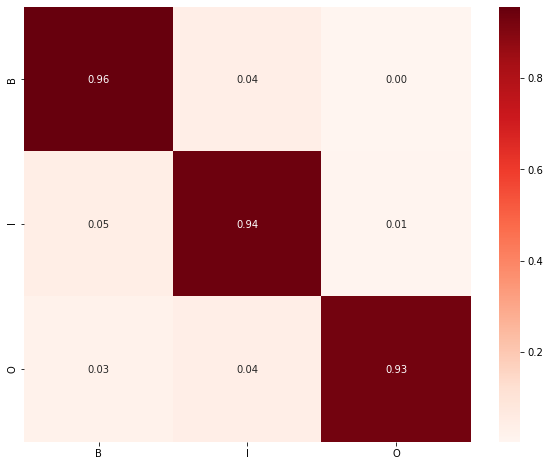

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion=np.zeros((3,3),)
for i,j in zip(l, p):
    confusion[tag2id[i]][tag2id[j]] += 1
conf = (confusion.T/(confusion.sum(axis=1))).T
conf = np.nan_to_num(conf)
plt.figure(figsize=(10,8))
ax = sns.heatmap(conf, annot=True, fmt=".2f",
                 cmap="Reds",
                 xticklabels=['B','I','O'],
                 yticklabels=['B','I','O'])

In [ ]:
def predict(batch,model):
  sentence = []
  tags = []
  for word, tag in zip(batch[0], batch[1]):
    word_embed = glove.get(word.lower(), torch.zeros(200))
    posid = 0#pos2id[tag]
    posid = torch.tensor([posid])
    word_embed = (torch.cat((word_embed, posid), 0))
    sentence.append(word_embed)
  sentence = torch.cat(sentence).view(len(sentence),-1)
  sentence = torch.stack([sentence])
  ds = TensorDataset(sentence)
  dl = DataLoader(ds,1)

  for i in dl:
    # print(i[0])
    out = model(i[0])

  # print(F.softmax(out[0]).argmax())

  return list(map(lambda x: id2tag[x],F.softmax(out[0]).argmax(dim=1).numpy()))

# Error Analysis

In [ ]:
i=0
incorrect, total = 0,0
for t in testset:
    pg = (list(zip(predict(t[0], model), t[2])))
    if sum([x!=y for x, y in pg]) > len(pg)//3:
        # print(t, pg)
        printable = ((list(zip(t[0], t[2], predict(t[0], model)))))
        for p in printable:
            print(f"<{p[0]}, {p[1]}, {p[2]}>,", end=" ")
        print()
        # print("\t".join(t[0]))
        # print("\t".join(t[2]))
        # print("\t".join(predict(t[0], model)))
    if incorrect > 1000:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<SHEARSON, B, O>, <LEHMAN, I, O>, <HUTTON, I, B>, <Inc, I, I>, <., O, O>, 
<Advanced, B, O>, <Cardiovascular, I, O>, <Systems, I, O>, <Inc., I, O>, <and, O, O>, <Cardiac, B, I>, <Pacemakers, I, O>, <Inc., I, I>, <units, I, B>, <led, B, B>, <growth, B, B>, <in, B, B>, <the, B, B>, <medical-instrument, I, I>, <systems, I, I>, <division, I, I>, <., O, O>, 
<'', O, O>, <Rival, B, O>, <Boston, I, O>, <Herald, I, O>, <columnist, I, I>, <Howie, I, O>, <Carr, I, B>, <,, O, O>, <who, B, B>, <usually, B, B>, <rails, B, I>, <at, B, B>, <Statehouse, B, B>, <``, I, O>, <hacks, I, B>, <'', I, O>, <and, I, O>, <nepotism, I, B>, <,, O, O>, <argued, B, B>, <that, B, B>, <the, B, B>, <new, I, I>, <drawings, I, I>, <were, B, B>, <designed, I, I>, <to, B, B>, <hide, I, I>, <Mr., B, B>, <Madden, I, O>, <'s, B, B>, <``, O, O>, <rapidly, B, I>, <growing, I, I>, <forehead, B, B>, <'', O, O>, <and, O, O>, <the, B, B>, <facial, I, I>, <defects, I, I>, <of, B, B>, <``, B, O>, <chinless, I, B>, <'', I, O>, <Dan, 

In [ ]:
testset[0][0]

array(['Rockwell', 'International', 'Corp.', "'s", 'Tulsa', 'unit',
       'said', 'it', 'signed', 'a', 'tentative', 'agreement', 'extending',
       'its', 'contract', 'with', 'Boeing', 'Co.', 'to', 'provide',
       'structural', 'parts', 'for', 'Boeing', "'s", '747', 'jetliners',
       '.'], dtype='<U54')